# Denoising Demonstration
Simple application of DnCNN using pre-trained models shipped with ``scico``.
Through convenience functions, the pre-trained DnCNNs can be constructed from
their variant names directly (e.g. 6L, 17N). However, our goal here is to dig
one layer deeper: understanding how these models are stored, and what is
required to construct new DnCNNs.

DnCNNs were pre-trained with ``flax`` and stored as python dictionaries in
*.npz format with keys: params, and batch_stats. The desired CNNs can be
constructed from the tuple (model, variables).


In [1]:
import jax
from scico.data import kodim23
from scico import plot
import scico.random
import scico.denoiser


In [2]:

# Check installed version of scico. The latest github version (as of 6/16/2023) 
# is significantly different from pip scico version (0.0.3)
assert scico.__version__>"0.0.4", f"Demo written for scico 0.0.4.dev0 < \
{scico.__version__} (installed) \nPlease install latest version from github \
https://github.com/lanl/scico"

# Utility plotting function

def plot_imrow(imgs,lbls=None,fig=None):
    """ Plot labeled images in a row"""
    N = len(imgs)
    if lbls is None:
        lbls = [None] * N
    if fig is None:
        fig = plot.figure(figsize=(6*len(figs), 6));
    for i, (img,s) in enumerate(zip(imgs,lbls)):
        ax = plot.plt.subplot2grid((1, N), (0, i),fig=fig)
        plot.imview(img, title=s, fig=fig, ax=ax);

# Built-in DnCNN constructor only accepts variant of pre-trained models.
# Our inherited DnCNN accepts (model,variables) for construction

class DnCNN(scico.denoiser.DnCNN): 
    def __init__(self, model,  variables):
        scico.denoiser.FlaxMap.__init__(self,model, variables)
        if model.channels == 2:
            self.is_blind = False
        else:
            self.is_blind = True

Read ground truth image (distributed with ``scico``) and generate noisy version.

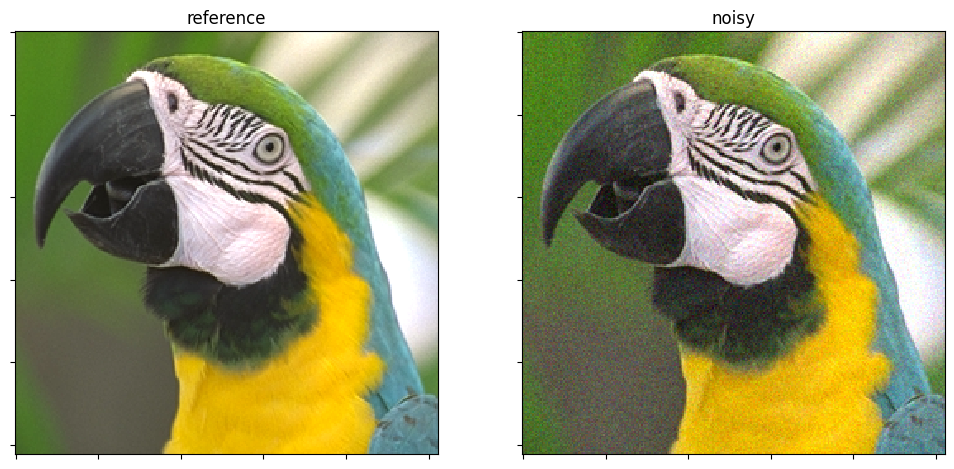

In [3]:
# Load truth
img = kodim23(asfloat=True)[160:416, 60:316]
img = jax.device_put(img)

# Generate noise
σ = 4e-2  # noise standard deviation
input_shape = img.shape
noise, key = scico.random.randn(input_shape, seed=0)
sn = img + σ * noise

# Plot truth and noise
figs = [img,sn]
lbls = ["reference", "noisy"]
plot_imrow(figs,lbls=lbls);

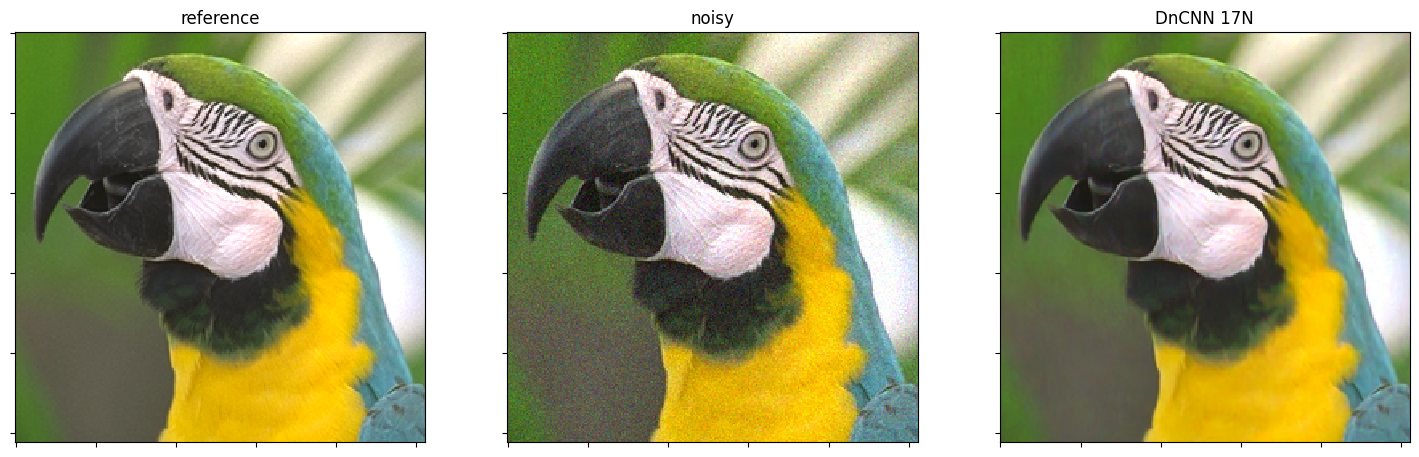

In [4]:
variant = "6L"
variant = "6N"
variant = "17N"

# To demonstrate constructing a DnCNN from (model, variables), we read in
# pre-trained models and directly construct the DnCNN
pre_trained = scico.denoiser.DnCNN(variant)
model = pre_trained.model
variables = pre_trained.variables

# Construct model
dncnn = DnCNN(model,variables)

# Denoise image
sigma = None if dncnn.is_blind else σ
y = dncnn(sn,sigma)

# Plot results
figs = [img,sn,y]
lbls = ["reference", "noisy", "DnCNN "+variant]
plot_imrow(figs,lbls=lbls)